In [ ]:
# default_exp enhanced_imageclassifiercleaner

In [ ]:
#hide
#ci
!pip install -U fastai --upgrade
!pip install -U jmd_imagescraper --upgrade

# Enhanced Image Classifier Cleaner

> an enhanced version of the fastai image classifier cleaner 
> which adds the apply and reset button widgets to actually update your dataset 
> instead of doing it separately in another step

In [ ]:
#hide
from fastai.vision.all import *

In [ ]:
#hide
project = 'pets'

In [ ]:
#hide
config = Config()
path = config.data_path/project
Path.BASE_PATH = path

In [ ]:
#hide
#ci
#fetch images from scratch
from jmd_imagescraper.core import duckduckgo_search
duckduckgo_search(path,'cats','cute cats',max_results=5) 
duckduckgo_search(path,'dogs','cute dogs',max_results=5) 

In [ ]:
#hide
dblock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(128),
    batch_tfms=aug_transforms()
)

In [ ]:
#hide
dls = dblock.dataloaders(path)

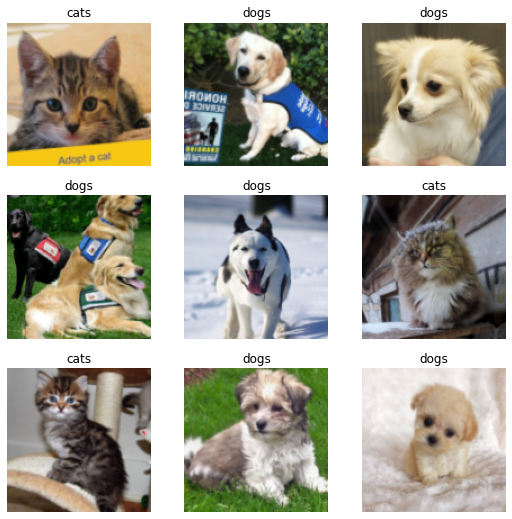

In [ ]:
#hide
#local
dls.show_batch()

In [ ]:
#hide
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [ ]:
#hide
#ci
learn.fine_tune(4)

In [ ]:
#hide
#local
learn.load('cat-dog-clean-learner-stage1');

In [ ]:
#hide
learn.dls = dls

### EnhancedImageClassifierCleaner Implementation

Import `fastai` widget dependencies and `fastcore` utility classes


In [ ]:
#export
from fastai.vision.widgets import ImagesCleaner, Dropdown, VBox, HBox, Label, Button, _get_iw_info
from fastcore.foundation import GetAttr, L
from fastcore.meta import delegates

Implement default `file_mover` that moves files when recategorized or relabeled that works with `parent_label` as the `get_y` datablock parameter._(This will not work with `RegexLabeller` since the label is not the parent directory)_  

In [ ]:
#export
import shutil
def parent_move_file(fn, newcat):
    new_path = fn.parent.parent/newcat
    if new_path.is_dir():
        shutil.move(str(fn), new_path)
        new_file = new_path/fn.name
        return new_file
    return fn

Implement the main widget `EnhancedImageClassifierCleaner` widget which in turn is based on the fastai `ImageClassifierCleaner` widget. 

In [ ]:
#export
@delegates(ImagesCleaner)
class EnhancedImageClassifierCleaner(GetAttr):
    def __init__(self, learn, file_mover=parent_move_file, **kwargs):
        self.learn = learn
        self.file_mover = file_mover
        vocab = learn.dls.vocab
        self.default = self.iw = ImagesCleaner(vocab, **kwargs)
        self.dd_cats = Dropdown(options=vocab)
        self.dd_ds   = Dropdown(options=('Train','Valid'))
        self.iwis = _get_iw_info(learn,0),_get_iw_info(learn,1)
        self.dd_ds.observe(self.on_change_ds, 'value')
        self.dd_cats.observe(self.on_change_ds, 'value')
        self.on_change_ds()
        # add message label and reset/apply buttons
        self.btn_apply_changes = Button(description='Apply', disabled=True)
        self.btn_reset_changes = Button(description='Reset', disabled=True)
        self.lbl_message = Label(value='No pending changes')
        self.btn_apply_changes.on_click(self.apply_changes)
        self.btn_reset_changes.on_click(self.reset_changes)
        self.update_message = False
        self.on_change_ds()
        self.path = learn.dls.path
        self.widget = VBox([
                    HBox([
                        VBox([self.dd_cats, 
                              self.dd_ds]),
                        VBox([self.btn_apply_changes, 
                              self.btn_reset_changes])]),
                    self.lbl_message, 
                    self.iw.widget])
        self.update_message = True
    def on_change_dd_item(self, change=None):
        if not self.update_message: 
            return       
        self.check_pending_changes()

    def check_pending_changes(self):
        if self.has_pending_changes():
            self.dd_cats.disabled = True
            self.dd_ds.disabled = True
            self.btn_apply_changes.disabled = False
            self.btn_reset_changes.disabled = False
            self.lbl_message.value = 'Apply or Reset Pending Changes'
        else:
            self.dd_cats.disabled = False
            self.dd_ds.disabled = False
            self.btn_apply_changes.disabled = True
            self.btn_reset_changes.disabled = True
            self.lbl_message.value = 'No pending changes'

    def has_pending_changes(self):
        return len(self.delete()) > 0 or len(self.change()) > 0
    
    def delete_dataset_item(self, items, iwi, idx):
        fn = self.fns[idx] # filename at index idx of fns (count of widgets)
        if fn is not None and fn.is_file():
            fn.unlink()
            iwi_indx = items.val2idx()[fn]
            if iwi_indx != -1:
                del iwi[iwi_indx]
                del items[iwi_indx]
            self.fns[idx] = None
            
    def recompute_loss(self, new_file):
        dl = self.learn.dls.test_dl([new_file],num_workers=0, with_labels=True)
        _,_,_,_,losses = learn.get_preds(dl=dl, 
                    with_input=True, with_loss=True, with_decoded=True)
        return losses[0]
    
    def reclassify_item(self, items, iwi, idx,  new_cat):
        fn = self.fns[idx]
        if fn is not None and fn.is_file():
            iwi_indx = items.val2idx()[fn]
            new_file = self.file_mover(fn, new_cat)
            if new_file != fn:
                items[iwi_indx] = new_file
                new_loss = self.recompute_loss(new_file)
                new_iwi_entry = (new_file, new_cat, new_loss)
                iwi[iwi_indx] = new_iwi_entry

    def apply_changes(self, b):  
        self.update_message = False
        ds_index = self.dd_ds.index # use train(0) or valid(1)
        iwi = self.iwis[ds_index] # get filenames,targs,loss for train/valid
        items = L(iwi).itemgot(0) # get filenames for  train/valid
        for idx,new_cat in self.change():
            if new_cat != self.dd_cats.value: # new_cat is not equal to existing cat
                self.reclassify_item(items, iwi, idx, new_cat)
        for idx in self.delete():
            self.delete_dataset_item(items, iwi, idx)
        new_fns = [fn for fn in self.fns if fn is not None]
        self.fns = new_fns
        self.on_change_ds()
        self.check_pending_changes()
        self.update_message = True

    def reset_changes(self, b):
        self.update_message = False
        dd_children = L(self.iw.widget.children).itemgot(1)
        for dd_child in dd_children:
            dd_child.value = '<Keep>'
        self.on_change_ds()
        self.check_pending_changes()
        self.update_message = True
    def _ipython_display_(self): display(self.widget)

    def on_change_ds(self, change=None):
        info = L(o for o in self.iwis[self.dd_ds.index] if o[1]==self.dd_cats.value)
        self.iw.set_fns(info.sorted(2, reverse=True).itemgot(0))
        dd_children = L(self.iw.widget.children).itemgot(1)
        for dd_child in dd_children:
            dd_child.observe(self.on_change_dd_item, 'value')

In [ ]:
#hide
len(learn.dls.train_ds), len(learn.dls.valid_ds)

(758, 189)

In [ ]:
#hide
len((path/'dogs').ls()),len((path/'cats').ls())

(479, 468)

### Usage Instructions
> The images are segregated into **Train** and **Valid** datasets and are 
> further segregated by category.

> The images shown by the cleaner are ordered by the model's uncertainty.
> The images where the classifier is least confident about is shown first, and
> a total of the top 30 images (in order of least confidence) is listed (the theory 
> being, that the images where the classifier most probably got it wrong are the ones
> where it was least confident about).

> So after either selecting some images for deletion or changing their categories, You can
> click to the `Apply` button to apply the changes, or click on `Reset` to revert all your
> pending changes.

> When cleaning your data, make sure to check on all categories for both **Train** and **Valid** datasets, and
> click on the `Apply` button to finalize the changes to your dataset.  


In [ ]:
cleaner = EnhancedImageClassifierCleaner(learn)
cleaner

![pic of enhanced-image-classifier-cleaner widget](images/enhanced-image-classifiercleaner.png)